# 1. Загрузка данных

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import math

In [2]:
df = pd.read_csv('daily-total-female-births-in-cal.csv')

Text(0.5, 1.0, 'Daily total female births in California\n')

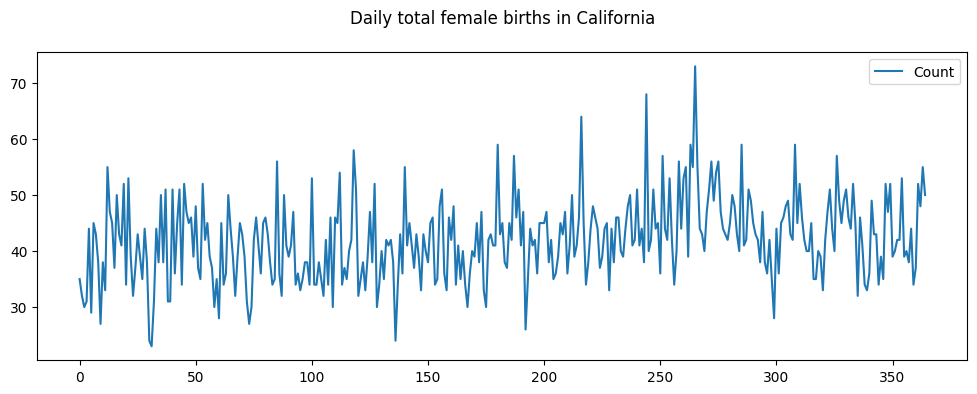

In [3]:
df_title = 'Daily total female births in California'

df.plot(figsize=(12, 4))
plt.title(f'{df_title}\n')

# 2. Матрица траекторий

In [4]:
df = df['Count']

In [5]:
N = len(df)
N

365

In [6]:
L = 120
K = N - L + 1

X = np.column_stack([df[i:i+L] for i in range(0, K)])
X

array([[35, 32, 30, ..., 38, 68, 40],
       [32, 30, 31, ..., 68, 40, 42],
       [30, 31, 44, ..., 40, 42, 51],
       ...,
       [42, 58, 51, ..., 37, 52, 48],
       [58, 51, 32, ..., 52, 48, 55],
       [51, 32, 35, ..., 48, 55, 50]])

In [7]:
X.shape

(120, 246)

Text(0.5, 1.0, "Матрица траекторий временного ряда 'Daily total female births in California'\n")

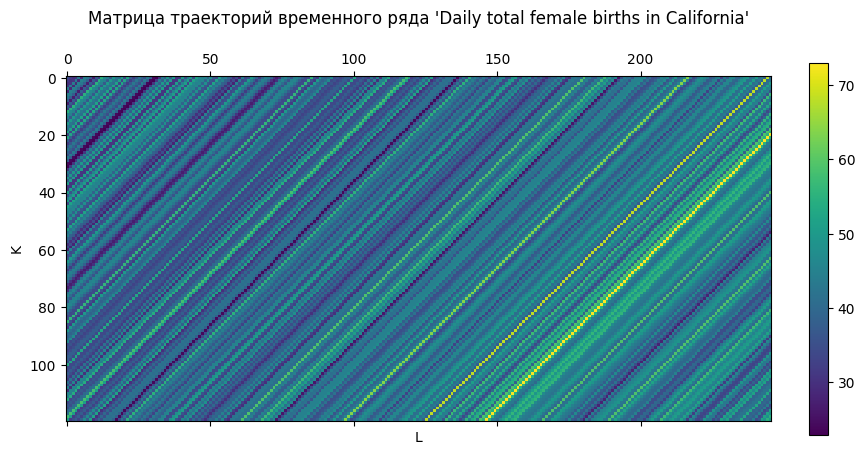

In [8]:
ax = plt.matshow(X)
plt.xlabel('L')
plt.ylabel('K')
plt.colorbar(ax.colorbar, fraction=0.025)
plt.title(f"Матрица траекторий временного ряда '{df_title}'\n")

По графику выше можно заметить наличие тренда (желтые линии).

# 3. Разложение матрицы траекторий

In [9]:
d = np.linalg.matrix_rank(X)
U, Sigma, V = np.linalg.svd(X)
V = V.T
X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

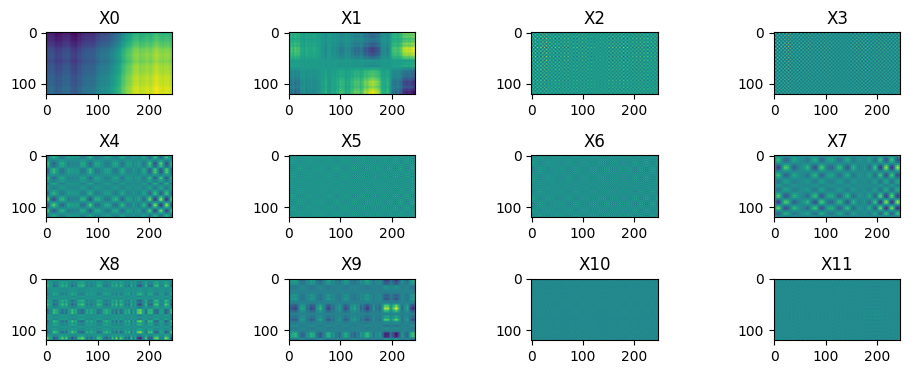

In [10]:
n = 12
r, c = 3, 4
plt.figure(figsize=(12, 4))

for i in range(n):
    plt.subplot(r, c, i+1)
    plt.subplots_adjust(hspace=1)
    plt.imshow(X_elem[i])
    plt.title(f'X{str(i)}')

X0, X1 изменяются медлено, что указывает на тренд. X4, X7 - переодичность. X8, X9 - переодичность и, возможно, тренд. Все остальные матрицы скорее похожи на шум.

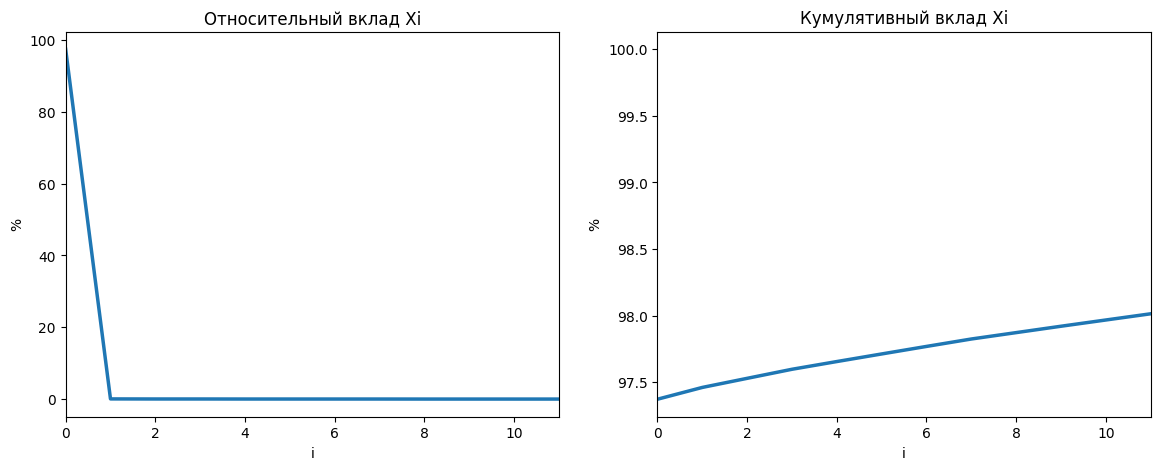

In [11]:
sigma_sumsq = (Sigma**2).sum()
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].plot(Sigma**2 / sigma_sumsq * 100, lw=2.5)
ax[0].set_xlim(0, 11)
ax[0].set_title('Относительный вклад Xi')
ax[0].set_xlabel('i')
ax[0].set_ylabel('%')

ax[1].plot((Sigma**2).cumsum() / sigma_sumsq * 100, lw=2.5)
ax[1].set_xlim(0, 11)
ax[1].set_title('Кумулятивный вклад Xi')
ax[1].set_xlabel('i')
ax[1].set_ylabel('%')
plt.show()

Кумулятивный вклад первых двух Xi в разложение X составляет примерно 97.5%.

Все остальные могут быть сгруппированы вместе при реконструкции временного ряда.

# 4. Матрица Ханкеля

In [12]:
from scipy.linalg import hankel

In [13]:
def X_to_TS(X_i):
    X_rev = X_i[::-1]
    res = np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])
    return res

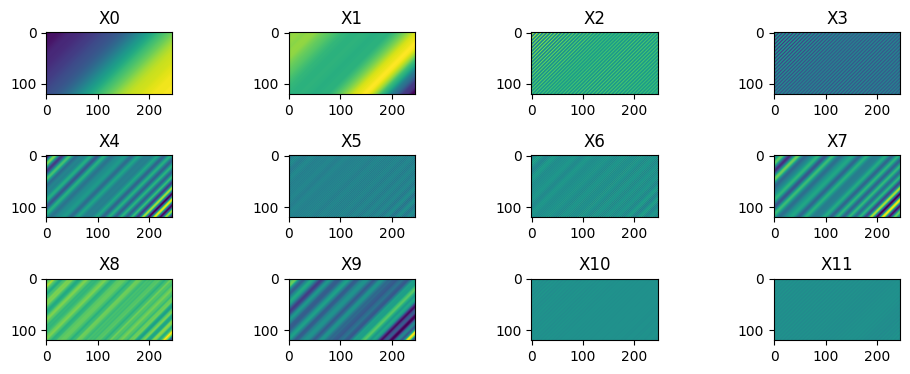

In [14]:
n = 12
r, c = 3, 4
plt.figure(figsize=(12, 4))

for i in range(n):
    plt.subplot(r, c, i+1)
    plt.subplots_adjust(hspace=1)
    m = X_to_TS(X_elem[i])
    plt.imshow(hankel(m[:L], m[L-1:]))
    plt.title(f'X{str(i)}')

По визуализации элементарных матриц Ханкеля также можно выделить следующие компоненты:

- тренд (X0, X1)
- периодичность 1й частоты (X4, X7)
- периодичность 2й частоты (X8, X9)
- периодичность 3й частоты (X5, X6)
- шум (X2, X3, X10, X11 и тд)

Теперь все это можно сгруппировать.

In [15]:
F_trend = X_to_TS(X_elem[[0,1]].sum(axis=0))
F_periodic1 = X_to_TS(X_elem[[4,7]].sum(axis=0))
F_periodic2 = X_to_TS(X_elem[[8,9]].sum(axis=0))
F_periodic3 = X_to_TS(X_elem[[5,6]].sum(axis=0))
F_noise = X_to_TS(np.concatenate((X_elem[[2,3]], X_elem[10:]), axis=0).sum(axis=0))

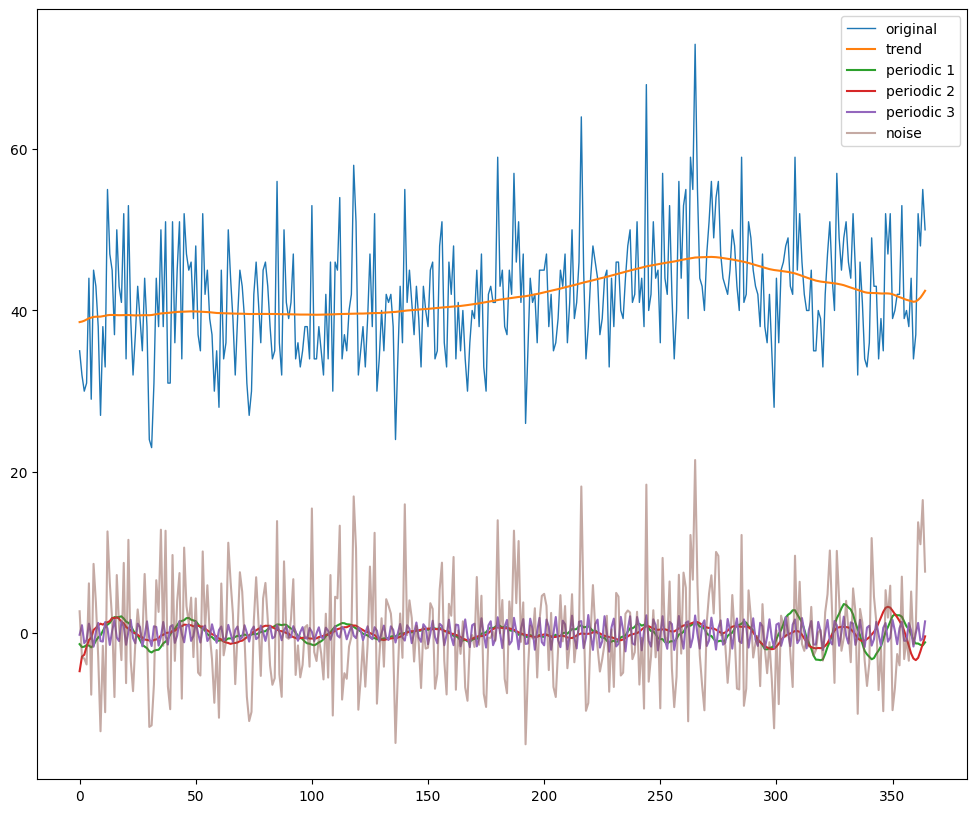

In [16]:
df.plot(figsize=(12, 10), lw=1)
plt.plot(F_trend)
plt.plot(F_periodic1)
plt.plot(F_periodic2)
plt.plot(F_periodic3)
plt.plot(F_noise, alpha=0.5)

legend = ['original', 'trend', 'periodic 1', 'periodic 2', 'periodic 3', 'noise']
plt.legend(legend)

plt.show()

# 5. W-корреляционная матрица

In [17]:
w = np.array(list(np.arange(L)+1) + [L]*(K-L-1) + list(np.arange(L)+1)[::-1])

F_elem = np.array([X_to_TS(X_elem[i]) for i in range(d)])
F_wnorms = np.array([w.dot(F_elem[i]**2) for i in range(d)])
F_wnorms = F_wnorms**-0.5

Wcorr = np.identity(d)

for i in range(d):
    for j in range(i+1,d):
        Wcorr[i,j] = abs(w.dot(F_elem[i]*F_elem[j]) * F_wnorms[i] * F_wnorms[j])
        Wcorr[j,i] = Wcorr[i,j]

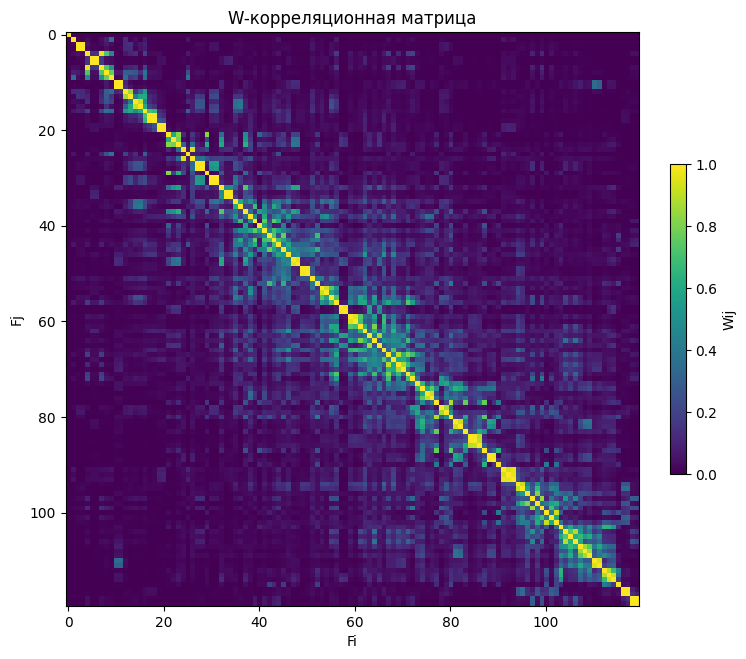

In [18]:
plt.figure(figsize=(8, 8))
ax = plt.imshow(Wcorr)
plt.xlabel('Fi')
plt.ylabel('Fj')
plt.colorbar(ax.colorbar, fraction=0.025)
ax.colorbar.set_label('Wij')
plt.clim(0,1)
plt.title('W-корреляционная матрица')
plt.show()

Визуально можно выделить 3 области: [0:20], [21:93], [94:120]


W-корреляционная матрица для первых 20 элеметов:

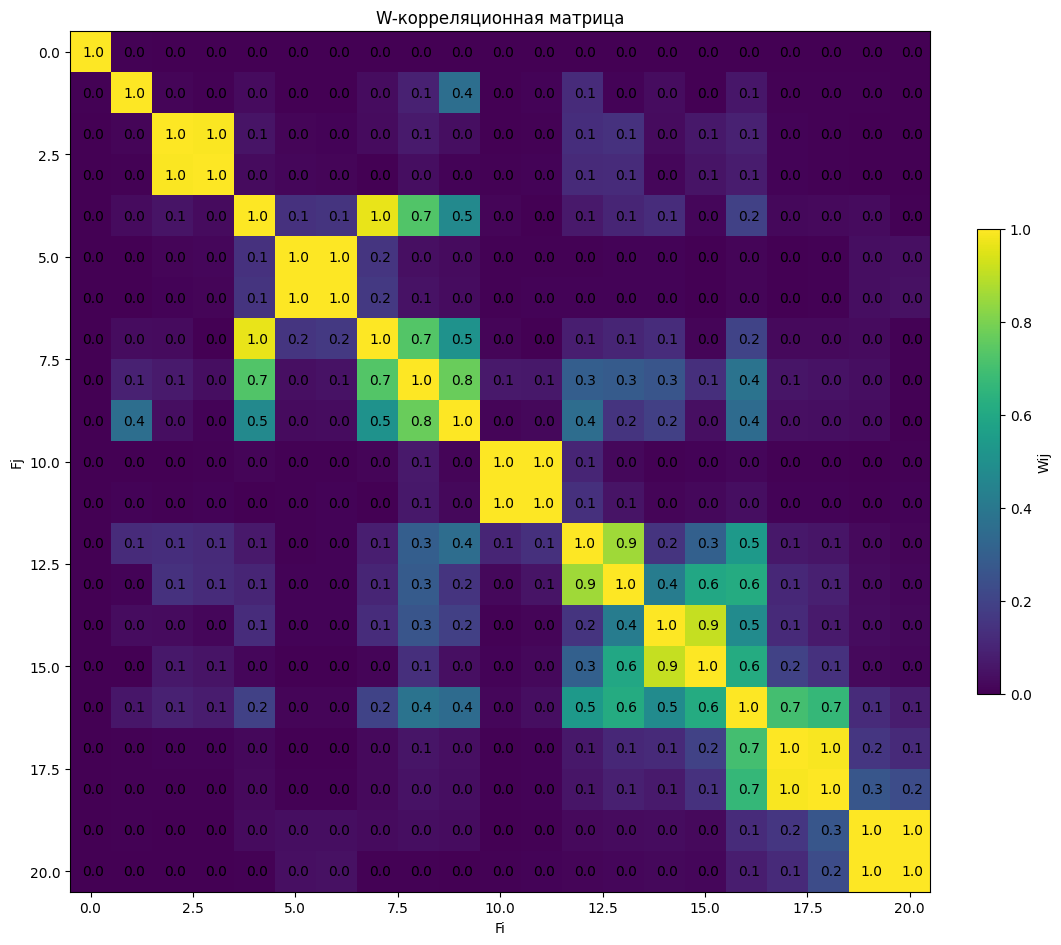

In [19]:
plt.figure(figsize=(12, 12))
ax = plt.imshow(Wcorr)
plt.xlabel('Fi')
plt.ylabel('Fj')
plt.colorbar(ax.colorbar, fraction=0.025)
ax.colorbar.set_label('Wij')

for i in range(21):
  for j in range(21):
    plt.annotate(round(Wcorr[i][j], 1), (i-.2, j+.1))

plt.xlim(-0.5, 20.5)
plt.ylim(20.5, -0.5)
plt.clim(0,1)
plt.title('W-корреляционная матрица')
plt.show()

W-корреляционная матрица для элеметов с 80 по 100:

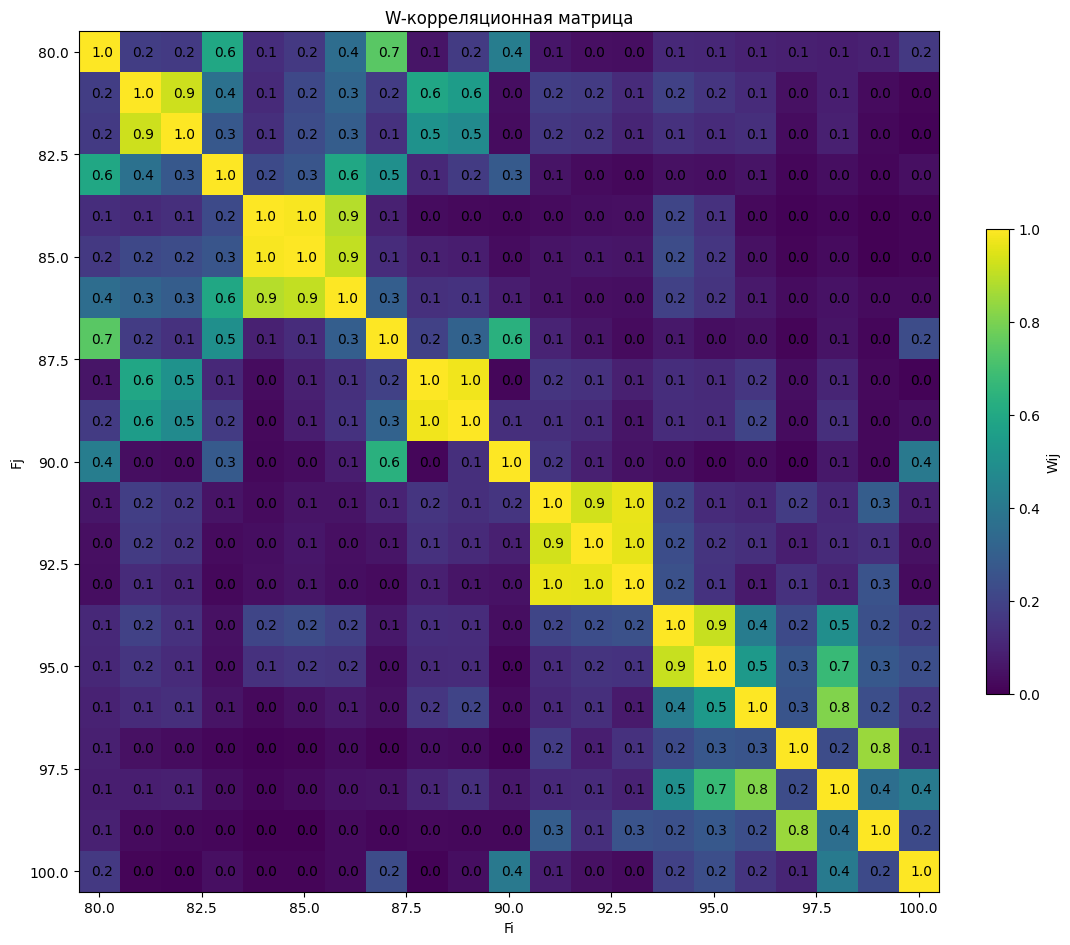

In [20]:
plt.figure(figsize=(12, 12))
ax = plt.imshow(Wcorr)
plt.xlabel('Fi')
plt.ylabel('Fj')
plt.colorbar(ax.colorbar, fraction=0.025)
ax.colorbar.set_label('Wij')

for i in range(80, 101):
  for j in range(80, 101):
    plt.annotate(round(Wcorr[i][j], 1), (i-.2, j+.1))

plt.xlim(79.5, 100.5)
plt.ylim(100.5, 79.5)
plt.clim(0,1)
plt.title('W-корреляционная матрица')
plt.show()

# SSA

## Класс SSA

In [22]:
class SSA(object):

    __supported_types = (pd.Series, np.ndarray, list)

    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.

        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list.
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.

        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        """

        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")

        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")

        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1

        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T

        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)

        self.TS_comps = np.zeros((self.N, self.d))

        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]

            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]

            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."

            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."

        # Calculate the w-correlation matrix.
        self.calc_wcorr()

    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d

        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)


    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.

        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]

        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)

    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """

        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])

        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)

        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5

        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]

    def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d

        if self.Wcorr is None:
            self.calc_wcorr()

        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)

        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max

        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)


## L = 2

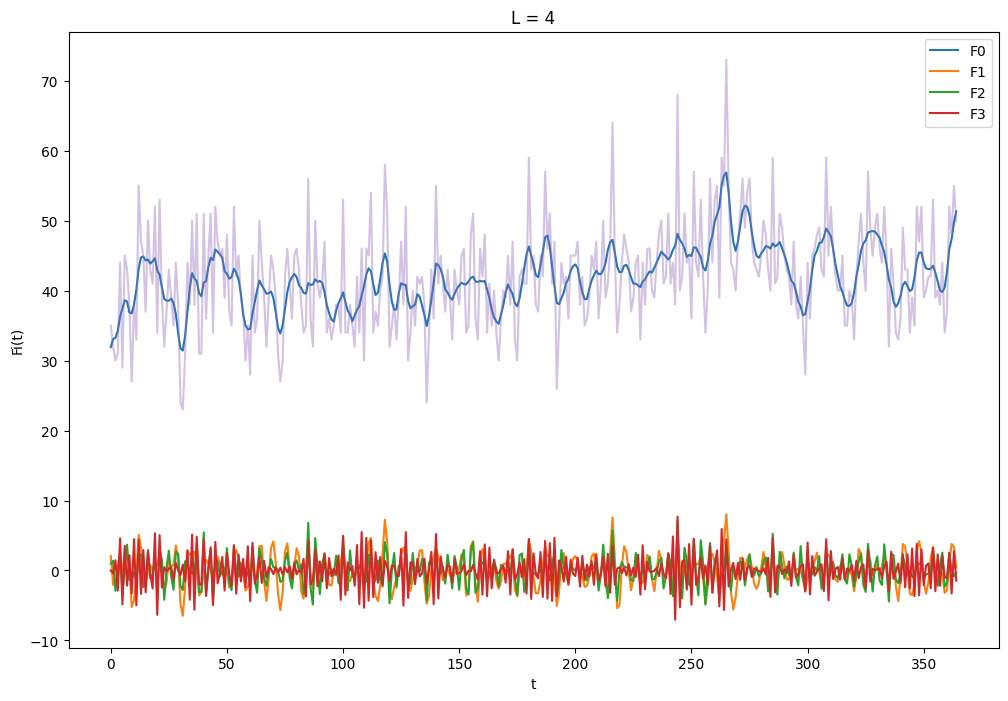

In [60]:
L_for_SSA = 4
F_ssa = SSA(df, L_for_SSA)
F_ssa.components_to_df().plot(figsize=(12, 8))
F_ssa.orig_TS.plot(alpha=0.4)
plt.xlabel('t')
plt.ylabel('Fi(t)')
plt.title(f'L = {L_for_SSA}')
plt.show()

## L = 50

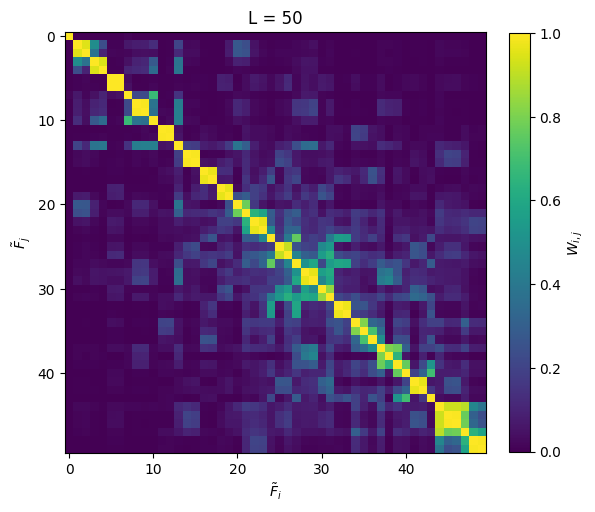

In [61]:
L_for_SSA = 50
F_ssa = SSA(df, L_for_SSA)
plt.figure(figsize=(6, 6))
F_ssa.plot_wcorr()
plt.title(f'L = {L_for_SSA}')
plt.show()

Визуально можно выделить 5 областей: [0], [1:4], [5,6], [7:13], [14:50]

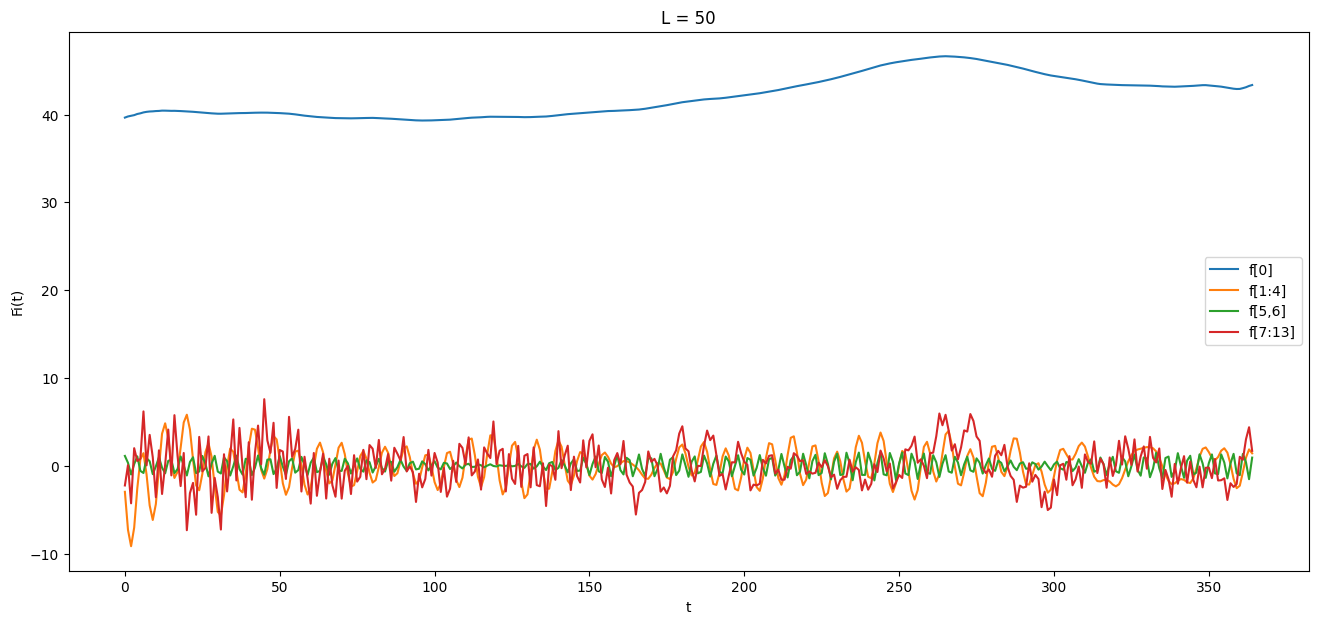

In [62]:
F_ssa.reconstruct(0).plot(figsize=(16, 7))
F_ssa.reconstruct(slice(1,4)).plot()
F_ssa.reconstruct(slice(5,6)).plot()
F_ssa.reconstruct(slice(7,13)).plot()
# F_ssa.reconstruct(slice(14,50)).plot() # без шума, чтобы не мешал
plt.xlabel('t')
plt.ylabel('Fi(t)')
plt.title(f'L = {L_for_SSA}')
plt.legend(['f[0]', 'f[1:4]', 'f[5,6]', 'f[7:13]'])
plt.show()

## L = 100

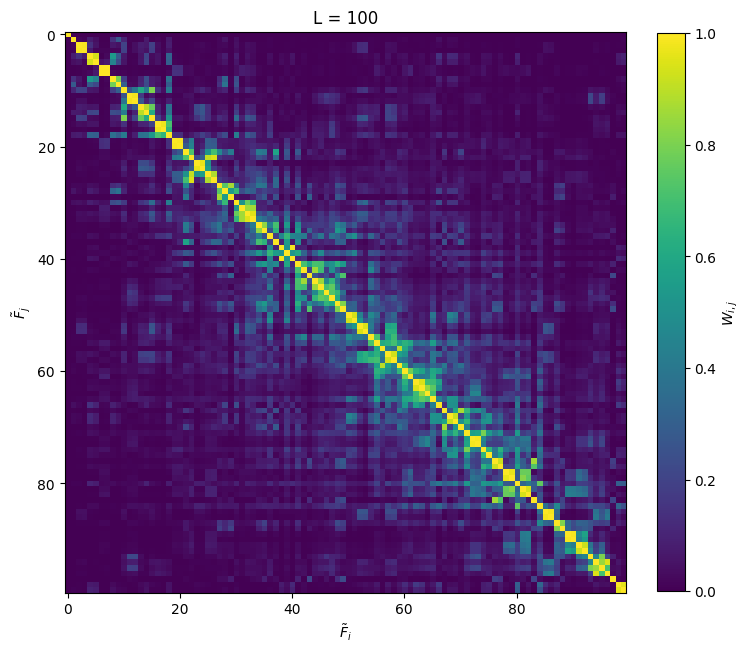

In [63]:
L_for_SSA = 100
F_ssa = SSA(df, L_for_SSA)
plt.figure(figsize=(8, 8))
F_ssa.plot_wcorr()
plt.title(f'L = {L_for_SSA}')
plt.show()

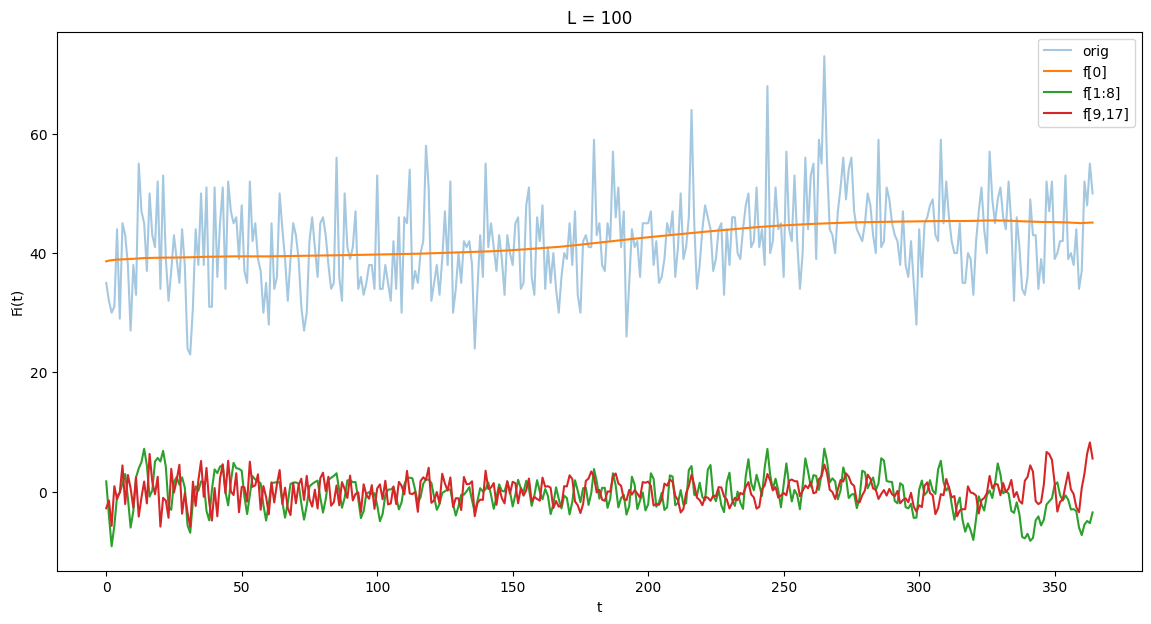

In [64]:
F_ssa.orig_TS.plot(alpha=0.4)
F_ssa.reconstruct(0).plot(figsize=(14, 7))
F_ssa.reconstruct(slice(1,8)).plot()
F_ssa.reconstruct(slice(9,17)).plot()
plt.xlabel('t')
plt.ylabel('Fi(t)')
plt.title(f'L = {L_for_SSA}')
plt.legend(['orig', 'f[0]', 'f[1:8]', 'f[9,17]'])
plt.show()

И отдельно шум (он чуть ли не повторяет исходный временной ряд):

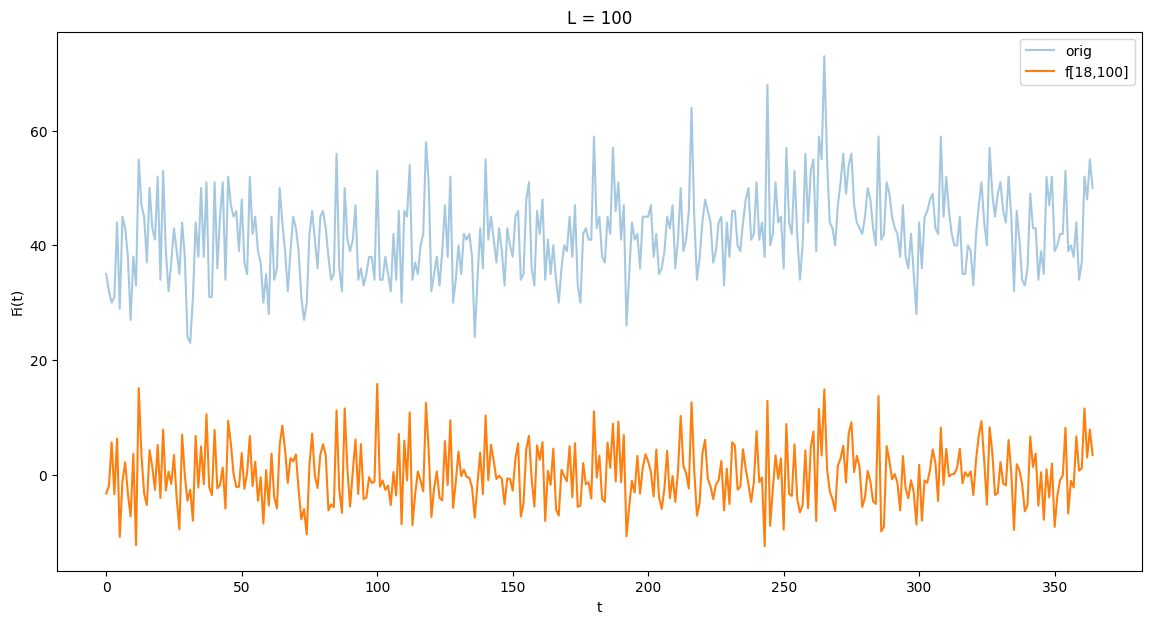

In [65]:
F_ssa.orig_TS.plot(alpha=0.4)
F_ssa.reconstruct(slice(18,100)).plot(figsize=(14, 7))
plt.xlabel('t')
plt.ylabel('Fi(t)')
plt.title(f'L = {L_for_SSA}')
plt.legend(['orig', 'f[18,100]'])
plt.show()

## L = 120

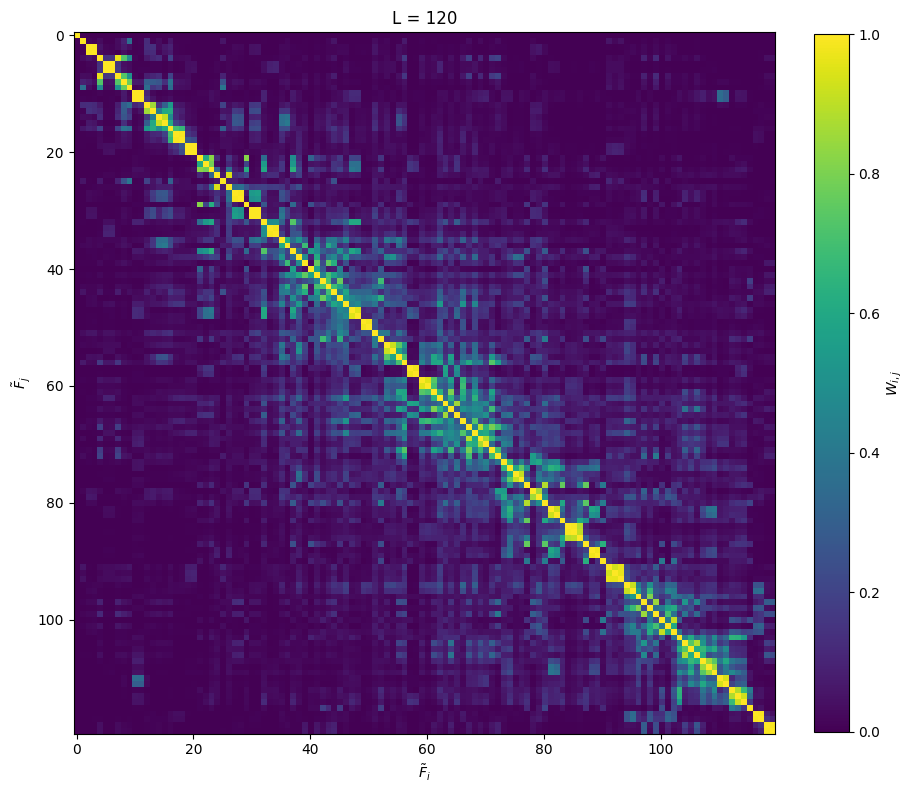

In [66]:
L_for_SSA = 120
F_ssa = SSA(df, L_for_SSA)
plt.figure(figsize=(10, 10))
F_ssa.plot_wcorr()
plt.title(f'L = {L_for_SSA}')
plt.show()

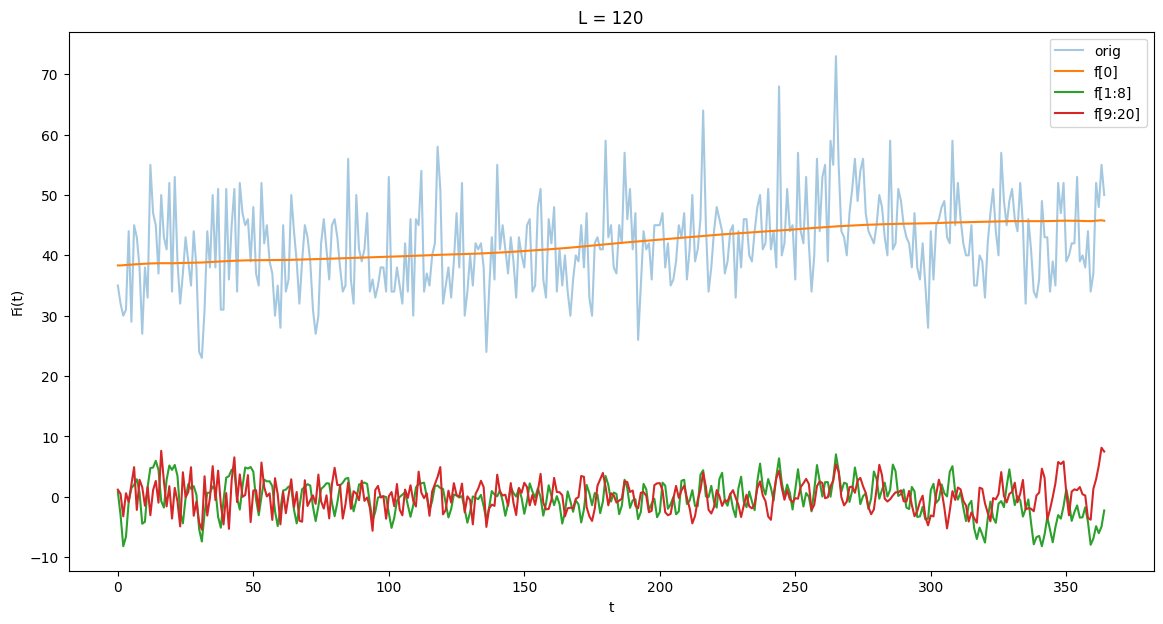

In [67]:
F_ssa.orig_TS.plot(alpha=0.4)
F_ssa.reconstruct(0).plot(figsize=(14, 7))
F_ssa.reconstruct(slice(1,8)).plot()
F_ssa.reconstruct(slice(9,20)).plot()
#F_ssa.reconstruct(slice(21,120)).plot()
plt.xlabel('t')
plt.ylabel('Fi(t)')
plt.title(f'L = {L_for_SSA}')
plt.legend(['orig', 'f[0]', 'f[1:8]', 'f[9:20]'])
plt.show()

Визуализация и границы областей не очень сильно отличаются от варианта с длиной окна, равной 100.

## L = 150

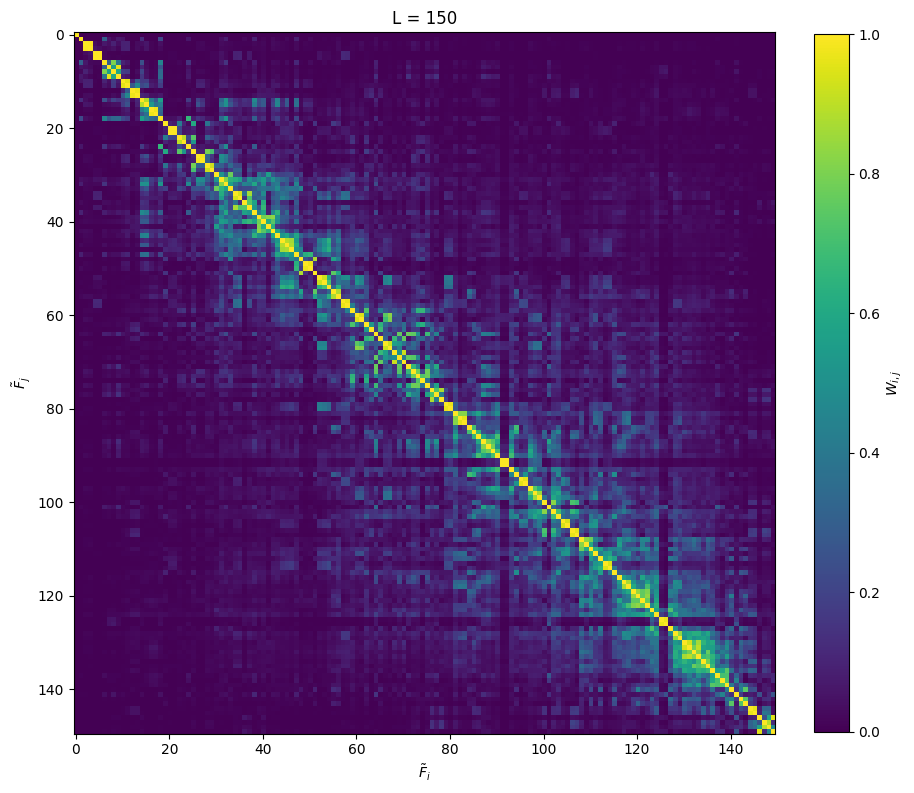

In [68]:
L_for_SSA = 150
F_ssa = SSA(df, L_for_SSA)
plt.figure(figsize=(10, 10))
F_ssa.plot_wcorr()
plt.title(f'L = {L_for_SSA}')
plt.show()

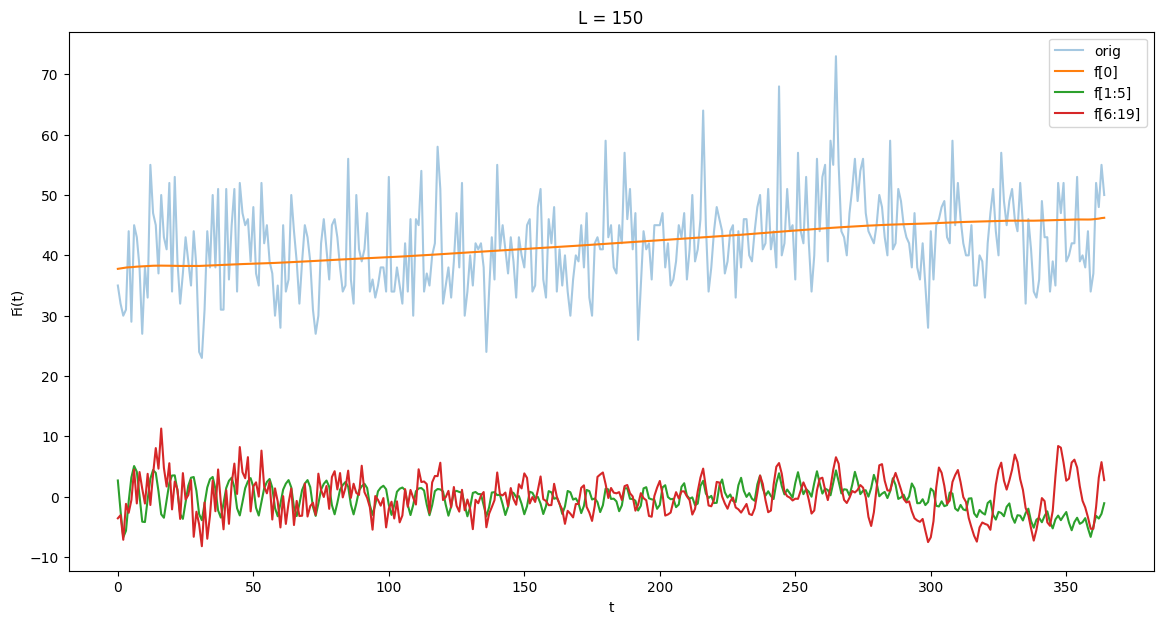

In [69]:
F_ssa.orig_TS.plot(alpha=0.4)
F_ssa.reconstruct(0).plot(figsize=(14, 7))
F_ssa.reconstruct(slice(1,5)).plot()
F_ssa.reconstruct(slice(6,19)).plot()
plt.xlabel('t')
plt.ylabel('Fi(t)')
plt.title(f'L = {L_for_SSA}')
plt.legend(['orig', 'f[0]', 'f[1:5]', 'f[6:19]'])
plt.show()

## L = N/2

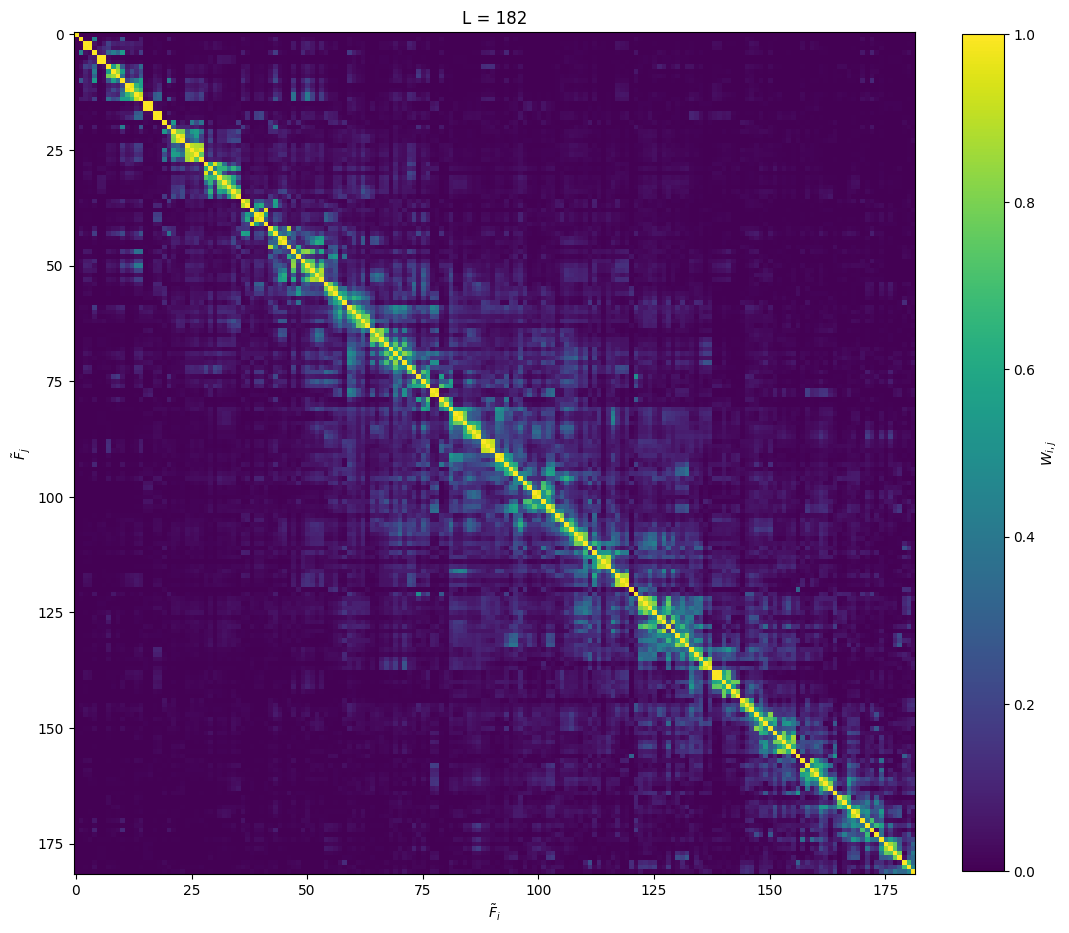

In [71]:
L_for_SSA = int(N/2)
F_ssa = SSA(df, L_for_SSA)
plt.figure(figsize=(12, 12))
F_ssa.plot_wcorr()
plt.title(f'L = {L_for_SSA}')
plt.show()

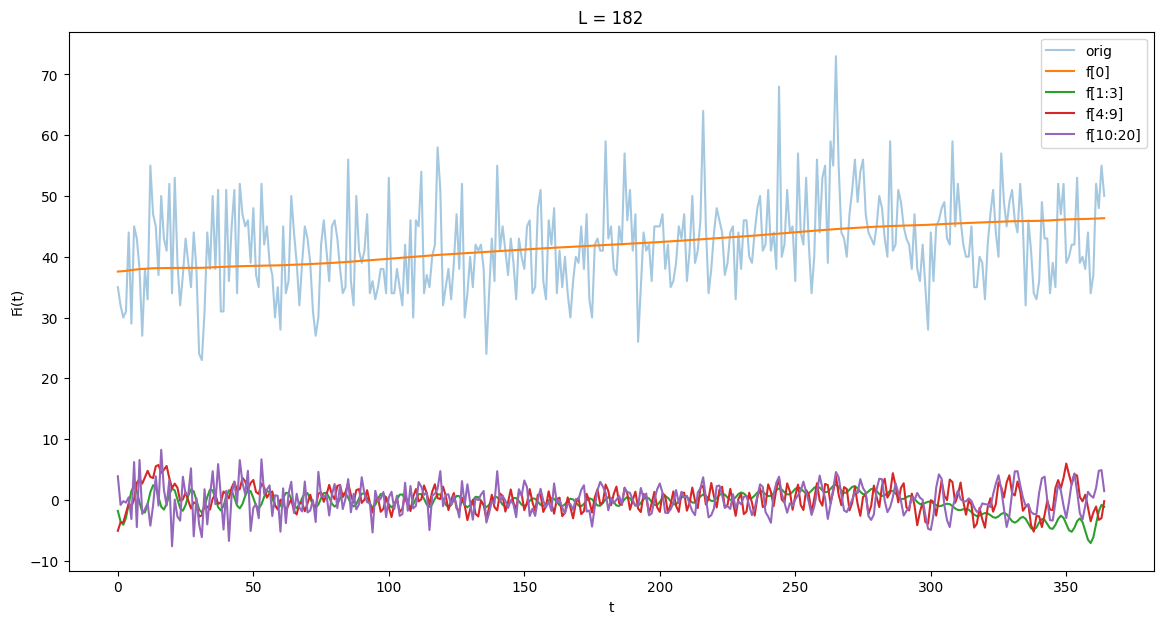

In [72]:
F_ssa.orig_TS.plot(alpha=0.4)
F_ssa.reconstruct(0).plot(figsize=(14, 7))
F_ssa.reconstruct(slice(1,3)).plot()
F_ssa.reconstruct(slice(4,9)).plot()
F_ssa.reconstruct(slice(10,20)).plot()
plt.xlabel('t')
plt.ylabel('Fi(t)')
plt.title(f'L = {L_for_SSA}')
plt.legend(['orig', 'f[0]', 'f[1:3]', 'f[4:9]', 'f[10:20]'])
plt.show()

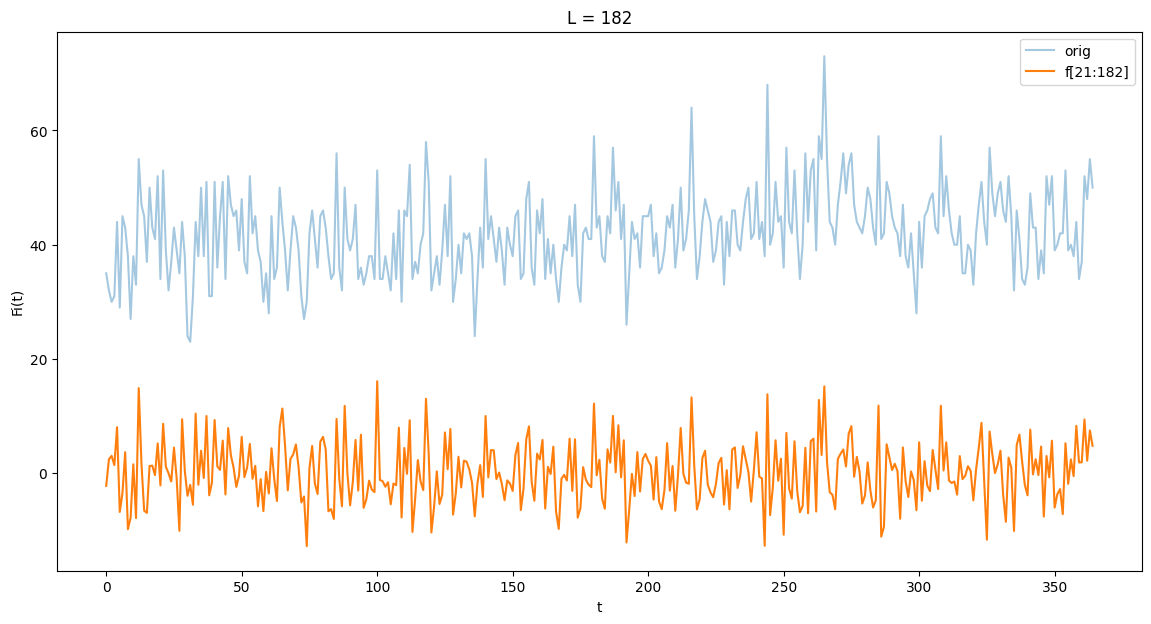

In [73]:
F_ssa.orig_TS.plot(alpha=0.4)
F_ssa.reconstruct(slice(21,182)).plot(figsize=(14, 7))
plt.xlabel('t')
plt.ylabel('Fi(t)')
plt.title(f'L = {L_for_SSA}')
plt.legend(['orig', 'f[21:182]'])
plt.show()

В случае L = N/2 компоненты периодичности выглядят более гладкими чем для размера окна 100, 120 и 150.